In [10]:
import numpy as np
import pandas as pd
import random

from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

import ast
from ast import literal_eval
import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt

from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('gdrive/My Drive/ise540/cleaned_data.csv')

In [11]:
#make hashtags into lists
l = []
s = []
for index, row in df.iterrows():
    ht = row['tweet']
    l.append(ast.literal_eval(ht))
    s.append(row['hashtags'])
    df_new = pd.DataFrame()
df_new['hashtags'] = s
df_new['tweet'] = l

In [13]:
#convert list to string
df_new['text'] = df_new['tweet'].apply(lambda x: ' '.join(x))

In [27]:
df_new

,hashtags,tweet,text
0,covid19,"[covid19, era, normal, influenza, season, lot,...",covid19 era normal influenza season lot peopl ...
1,greenpass,"[covid19, era, normal, influenza, season, lot,...",covid19 era normal influenza season lot peopl ...
2,greenpass,"[brussel, march, greenpass, novaccinepassport,...",brussel march greenpass novaccinepassport nova...
3,novaccinepassports,"[brussel, march, greenpass, novaccinepassport,...",brussel march greenpass novaccinepassport nova...
4,novaccinemandates,"[brussel, march, greenpass, novaccinepassport,...",brussel march greenpass novaccinepassport nova...
...,...,...,...
30312,covidiots,"[dr, fleme, covid, caus, solut, covid19, covid...",dr fleme covid caus solut covid19 covid1984 co...
30313,vaccinesideeffects,"[dr, fleme, covid, caus, solut, covid19, covid...",dr fleme covid caus solut covid19 covid1984 co...
30314,vaccinepassport,"[dr, fleme, covid, caus, solut, covid19, covid...",dr fleme covid caus solut covid19 covid1984 co...
30315,vaccinemandate,"[dr, fleme, covid, caus, solut, covid19, covid...",dr fleme covid caus solut covid19 covid1984 co...


In [23]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_new['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 30418 unique tokens.


In [24]:
#tokennize words
X = tokenizer.texts_to_sequences(df_new['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (30317, 100)


In [25]:
Y = pd.get_dummies(df_new['hashtags']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (30317, 60)


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [28]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(60, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
342/342 [==============================] - 119s 337ms/step - loss: 2.8924 - accuracy: 0.3306 - val_loss: 2.5366 - val_accuracy: 0.3759
Epoch 2/5
342/342 [==============================] - 116s 339ms/step - loss: 2.3169 - accuracy: 0.3990 - val_loss: 2.2121 - val_accuracy: 0.3904
Epoch 3/5
342/342 [==============================] - 117s 342ms/step - loss: 2.0709 - accuracy: 0.4039 - val_loss: 2.0390 - val_accuracy: 0.3846
Epoch 4/5
342/342 [==============================] - 117s 342ms/step - loss: 1.9065 - accuracy: 0.4086 - val_loss: 1.8982 - val_accuracy: 0.3714
Epoch 5/5
342/342 [==============================] - 115s 336ms/step - loss: 1.7790 - accuracy: 0.4131 - val_loss: 1.8246 - val_accuracy: 0.3660


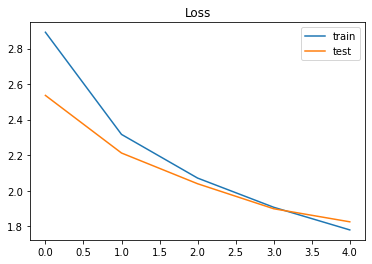

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

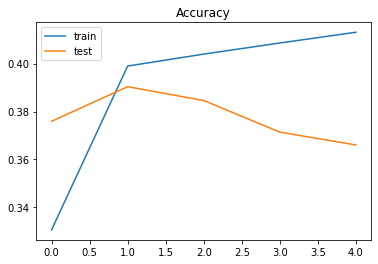

In [30]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          100000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 60)                6060      
                                                                 
Total params: 186,460
Trainable params: 186,460
Non-trainable params: 0
_________________________________________________________________


In [32]:
Y = pd.get_dummies(df['hashtags'])
a = pd.DataFrame(Y.idxmax(axis=1),columns = ['tag'])

In [34]:
pred = model.predict(X_test)
res = pd.DataFrame(pred)
res.idxmax(axis="columns").value_counts()

53    2350
55     675
8      556
18     358
58     181
32     176
36     160
26     159
20     150
24     102
29     100
12      98
33      98
56      89
7       83
13      75
31      69
14      68
28      65
30      56
22      53
39      52
37      38
6       37
50      32
11      32
10      30
16      23
43      17
5       11
3        9
1        9
46       8
2        7
49       7
52       6
59       4
21       4
0        4
9        3
15       3
17       2
27       2
25       1
23       1
35       1
dtype: int64

In [41]:
print(classification_report(Y_test,pred, labels = [53,55,8,18]))

              precision    recall  f1-score   support

          53       0.54      0.75      0.63      1692
          55       0.52      0.62      0.56       564
           8       0.22      0.26      0.24       477
          18       0.49      0.80      0.61       222

   micro avg       0.49      0.65      0.56      2955
   macro avg       0.44      0.61      0.51      2955
weighted avg       0.48      0.65      0.55      2955

